In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
import sys
from tkinter import *
import os
from pandastable import Table, TableModel
# from openbb_terminal.sdk import openbb
# from scipy.optimize import minimize

In [2]:
# the documentation page for yfinance https://pypi.org/project/yfinance/
import yfinance as yf

In [3]:
# find dates for import
today = datetime.today().strftime('%Y-%m-%d')
five = (datetime.today() - relativedelta(years=5)).strftime('%Y-%m-%d')

In [4]:
# list of tickers from tkinter front-end
port_list = ['COST', 'WMT', 'TGT', 'DG']

In [13]:
# calculate the number of stocks in portfolio
N = len(port.columns)

In [14]:
N

4

In [17]:
port_list = list(port.columns)

In [18]:
port_list

['COST', 'WMT', 'TGT', 'DG']

In [5]:
# create class to convert string to object location name
class classthing:
    def __init__(self, name):
        self.name = name

# dictionary to hold ticker and pd.series object location name        
dct = {name: classthing(name) for name in port_list}

In [6]:
# get price data for tickers in list using yfinance where pd.series are memory location names
for stk in port_list:
    dct[stk] = yf.download(stk, start=five, end=today)['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [35]:
# Get 5 years of adjusted close price data of selected stocks
# COST = pd.read_csv('COST.csv', index_col='Date', parse_dates=True)['Adj Close']
# WMT = pd.read_csv('WMT.csv', index_col='Date', parse_dates=True)['Adj Close']
# TGT = pd.read_csv('TGT.csv', index_col='Date', parse_dates=True)['Adj Close']
# DG = pd.read_csv('DG.csv', index_col='Date', parse_dates=True)['Adj Close']

# use openbb to retrieve pricing data
COST = openbb.stocks.load('COST', start_date=five, end_date=today)['Adj Close']
WMT = openbb.stocks.load('WMT', start_date=five, end_date=today)['Adj Close']
TGT = openbb.stocks.load('TGT', start_date=five, end_date=today)['Adj Close']
DG = openbb.stocks.load('DG', start_date=five, end_date=today)['Adj Close']

# df = openbb.stocks.load('STNG', start_date='2023-01-01', end_date='2023-02-15')['Adj Close']

Loading Daily data for COST with starting period 2018-02-28.

Loading Daily data for WMT with starting period 2018-02-28.

Loading Daily data for TGT with starting period 2018-02-28.

Loading Daily data for DG with starting period 2018-02-28.

In [7]:
# combine the four stocks into a single dataframe
# axis =1 to show that the concatenation is to be done on columns not rows
port = pd.concat([dct[x] for x in port_list], axis=1)
# ticker names to portfolio
port.columns = port_list

In [8]:
# SKIP - display only
port

,COST,WMT,TGT,DG
Date,,,,
2018-03-07 00:00:00-05:00,175.067261,80.073090,63.553543,85.461792
2018-03-08 00:00:00-05:00,173.506790,80.715752,62.058769,82.268562
2018-03-09 00:00:00-05:00,176.207138,81.450188,62.717178,83.119446
2018-03-12 00:00:00-04:00,176.945312,80.853447,62.877335,84.716042
2018-03-13 00:00:00-04:00,175.160675,81.064583,63.322193,85.595627
...,...,...,...,...
2023-02-28 00:00:00-05:00,484.179993,142.130005,168.500000,216.300003
2023-03-01 00:00:00-05:00,478.670013,140.149994,162.399994,213.789993
2023-03-02 00:00:00-05:00,485.690002,140.500000,165.940002,216.229996


In [27]:
os.remove('mc.pickle')

In [63]:
# calculate the number of stocks in portfolio
N = len(port_list)

In [64]:
# make a function to generate random portfolio weights
def gen_weights(N):
    weights = np.random.random(N)
    return weights / np.sum(weights)

In [65]:
# make a function to calculate an annualized portfolio return given a certain 
# portfolio weighting
def calculate_returns(weights, log_rets):
    # annualize return
    return np.sum(log_rets.mean() * weights) * 252

In [66]:
def calculate_volatility(weights, log_rets_cov):
    annualized_cov = np.dot(log_rets.cov() * 252, weights)
    vol = np.dot(weights.transpose(), annualized_cov)
    return np.sqrt(vol)

In [67]:
# recalculating the variables just to make this readable
log_rets = np.log(port / port.shift(1))
log_rets_cov = log_rets.cov()

In [68]:
# list to hold the returns from the monte carlo simulation
mc_portfolio_returns = []
mc_portfolio_vol = []
mc_weights = []

# note that the number of stocks in the portfolio makes the length of
# the simulation grow exponentially in complexity
for sim in range(6000):
    
    weights = gen_weights(N)
    mc_weights.append(weights)
    sim_returns = calculate_returns(weights, log_rets)
    mc_portfolio_returns.append(sim_returns)
    sim_volatility = calculate_volatility(weights, log_rets_cov)
    mc_portfolio_vol.append(sim_volatility)

In [69]:
# assume zero risk-free rate to calculate Sharpe ratio
mc_sharpe_ratios = np.array(mc_portfolio_returns / np.array(mc_portfolio_vol))

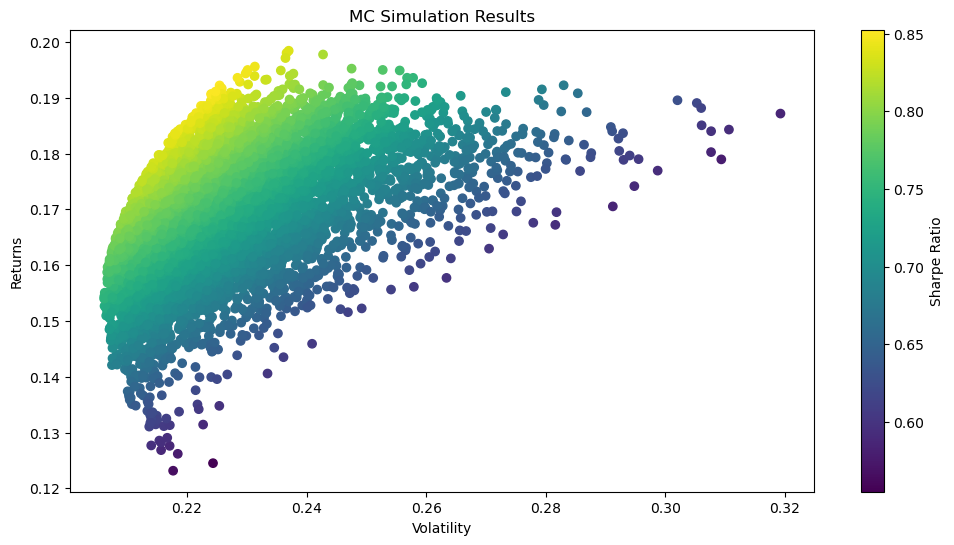

In [70]:
fig = plt.figure(figsize=(12,6))
plt.scatter(mc_portfolio_vol, mc_portfolio_returns, c=mc_sharpe_ratios)
plt.colorbar(label='Sharpe Ratio')
# plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = False
# plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = True
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.title('MC Simulation Results')
plt.show()

In [16]:
# display & error check section 1/3
# now to find the optimal combination
np.argmax(mc_sharpe_ratios)

1395

In [17]:
# display & error check section 2/3
mc_sharpe_ratios[np.argmax(mc_sharpe_ratios)]

0.8552844350597357

In [18]:
# display & error check section 3/3
mc_weights[np.argmax(mc_sharpe_ratios)]

array([0.70882632, 0.0015226 , 0.04225527, 0.24739582])

In [73]:
df_weights = pd.DataFrame(np.row_stack(mc_weights))
df_weights.columns = port_list

In [74]:
df_portfolio_returns = pd.DataFrame(np.row_stack(mc_portfolio_returns))
df_portfolio_returns.columns = ['Return']

In [75]:
df_portfolio_vol = pd.DataFrame(np.row_stack(mc_portfolio_vol))
df_portfolio_vol.columns = ['Volatility']

In [76]:
df_portfolio_sharpe = pd.DataFrame(np.row_stack(mc_sharpe_ratios))
df_portfolio_sharpe.columns = ['Sharpe']

In [77]:
df_portfolio_mc = pd.concat([df_weights, df_portfolio_returns, df_portfolio_vol, df_portfolio_sharpe], axis=1)

In [25]:
df_portfolio_mc.iloc[np.argmax(mc_sharpe_ratios)]

COST          0.708826
WMT           0.001523
TGT           0.042255
DG            0.247396
Return        0.194291
Volatility    0.227165
Sharpe        0.855284
Name: 1395, dtype: float64

In [78]:
mc_final = df_portfolio_mc.sort_values('Sharpe', ascending=False)

In [27]:
mc_final.head(10)

,COST,WMT,TGT,DG,Return,Volatility,Sharpe
1395,0.708826,0.001523,0.042255,0.247396,0.194291,0.227165,0.855284
2905,0.754173,0.000324,0.051105,0.194398,0.195803,0.229233,0.854165
2537,0.647979,0.025994,0.032854,0.293174,0.190896,0.223986,0.852268
4863,0.630221,0.008023,0.055738,0.306018,0.191822,0.225133,0.852039
4923,0.677020,0.020626,0.081159,0.221196,0.192775,0.226278,0.851936
1506,0.639871,0.002148,0.094217,0.263764,0.193028,0.226700,0.851468
2330,0.750517,0.039474,0.038025,0.171984,0.193105,0.227048,0.850503
2153,0.741401,0.015014,0.091622,0.151963,0.195131,0.229625,0.849780
4150,0.607598,0.011278,0.029777,0.351348,0.190588,0.224332,0.849577
2080,0.667388,0.070800,0.005082,0.256730,0.188300,0.221752,0.849146


In [19]:
## RETURN GRAPHING SECTION
# now get a second dataframe based on the stock prices to compute the
# daily returns.  Also drop the first row that will be blank
port_returns = port.pct_change(1).dropna()

In [23]:
cumul_return2.columns

Index(['COST', 'WMT', 'TGT', 'DG'], dtype='object')

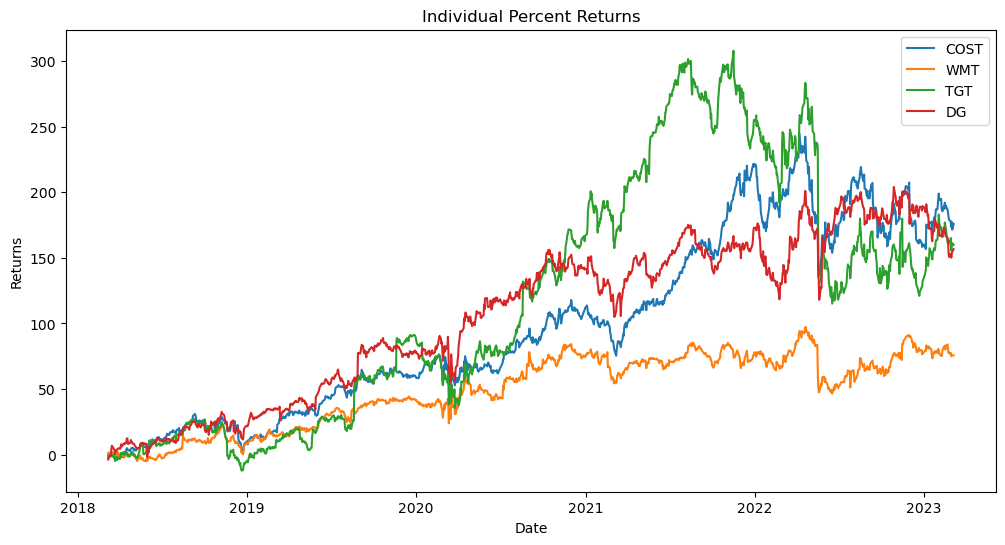

In [24]:
# now combining all four into one step and graphing it
cumul_return2 = 100 * ((1 + port_returns).cumprod() - 1)

fig = plt.figure(figsize=(12,6))
plt.plot(cumul_return2)
plt.ylabel('Returns')
plt.xlabel('Date')
plt.title('Individual Percent Returns')
plt.legend(cumul_return2.columns)
plt.show()

In [84]:
class DfDisplay:
    def __init__(self, master):
        self.master = master
        master.title("Top Ten Weights")
        self.button1 = Button(
            master, text="Show Weights", command=self.display_df_in_new_window
        )
        self.button1.place(x=60, y=100, height=44, width=127)

    def get_data(self):
        df = mc_final.head(10)
        return df

    def display_df_in_new_window(self):
        frame = Toplevel(self.master)
        self.table = Table(
            frame, dataframe=self.get_data(), showtoolbar=True, showstatusbar=True
        )
        self.table.show()

root = Tk()
my_gui = DfDisplay(root)
root.geometry('600x450')
root.mainloop()

/tmp/ipykernel_12599/4113663741.py:19: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  self.table.show()
